In [1]:
import numpy as np
import pandas as pd
import xarray as xr
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
from netCDF4 import Dataset, date2num, num2date
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
import os

from matplotlib import cm
import matplotlib.cbook as cbook
import matplotlib.colors as colors

from keras import backend as K
from tensorflow.keras.utils import get_custom_objects


def custom_activation(x):
    return (K.exp(x) - 2)

get_custom_objects().update({'custom_activation': custom_activation})

%matplotlib inline

2024-05-24 12:23:57.469134: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

i = 0
tlen = 0


metaDataIndex = ['time',
                 'lat', 
                 'lon',
                 'U10N',
                 'U10N_dir',
                 'SST',
                 'RH',
                 'AIRT',
                 'RAIN']

nvars =len(metaDataIndex)
metaData = np.empty((0,nvars), dtype=float)

allDS = xr.Dataset()

nfiles = 0
for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    dataFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_withRAIN_COARE3p5_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(dataFileName):
        print(f'file number: {nfiles+1:2d}')
        df = xr.open_dataset(dataFileName)
        df = df.sortby('time')
        
        ndata = len(df['time'])
        lat_da = xr.DataArray(data=np.ones(ndata) * LAT, dims=['time'],
                             attrs = {
                                 'units': 'degrees North',
                                 'long_name': 'buoy lat location'
                             })
        lon_da = xr.DataArray(data=np.ones(ndata) * LON, dims=['time'],
                             attrs = {
                                 'units': 'degrees East',
                                 'long_name': 'buoy longitude location'
                             })
        df['lat'] = lat_da
        df['lon'] = lon_da

        

        tval = df['time'].to_numpy()

        # twoHrVarWspd = np.zeros((ndata), dtype=float)*np.nan
        # twoHrVarWdir = np.zeros((ndata), dtype=float)*np.nan

        twoHrStdWspd = np.zeros((ndata), dtype=float)*np.nan
        twoHrStdWdir = np.zeros((ndata), dtype=float)*np.nan

        npoints4VarDir = np.zeros((ndata), dtype=float)*np.nan
        npoints4VarSpd = np.zeros((ndata), dtype=float)*np.nan

        wspd = df['U10N'].to_numpy()
        wdir = df['U10_direction'].to_numpy()
        
        for i in range(6,ndata-6):
            thisTvalBox = tval[i-6:i+6]
            tdiff = thisTvalBox - tval[i]
            mask = abs(tdiff) < np.timedelta64(timedelta(seconds=3600))

            thisWspdBox = wspd[i-6:i+6]
            thisWdirBox = wdir[i-6:i+6]
        
            spdArr = thisWspdBox[mask]
            dirArr = thisWdirBox[mask]

            npoints4varSpd = np.sum(~np.isnan(spdArr))
            npoints4varDir = np.sum(~np.isnan(dirArr))

            if npoints4varSpd > 5 and npoints4varDir > 5:
                twoHrStdWspd[i] = np.nanstd(spdArr)
                twoHrStdWdir[i] = np.nanstd(dirArr) 
        
               


        twoHrStdWspd_da = xr.DataArray(data=twoHrStdWspd, dims=['time'],
                             attrs = {
                                 'units': 'm/sec',
                                 'long_name': 'std. deviation of wind speed in two-hour running window'
                             })

        twoHrStdWdir_da = xr.DataArray(data=twoHrStdWdir, dims=['time'],
                             attrs = {
                                 'units': 'm/sec',
                                 'long_name': 'std. deviation of wind direction in two-hour running window'
                             })

        npoints4VarSpd_da = xr.DataArray(data=npoints4VarSpd, dims=['time'],
                             attrs = {
                                 'units': 'N/A',
                                 'long_name': 'number of data used for std. deviation of wind speed in two-hour running window'
                             })

        npoints4VarDir_da = xr.DataArray(data=npoints4VarDir, dims=['time'],
                             attrs = {
                                 'units': 'N/A',
                                 'long_name': 'number of data used for std. deviation of wind direction in two-hour running window'
                             })
            
        df['twoHrStdWspd'] = twoHrStdWspd_da
        df['twoHrStdWdir'] = twoHrStdWdir_da
        df['npoints4VarSpd'] = npoints4VarSpd_da
        df['npoints4VarDir'] = npoints4VarDir_da
            
        ds2 = Dataset(deployFileName)
        cdfTime = ds2.variables['startDate']
        timeUnit = cdfTime.units
        timeArr = np.array(cdfTime)
        cftimes=num2date(timeArr, timeUnit)
        startDates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])
        startDates = np.array([np.datetime64(dt) for dt in startDates])

        cdfTime = ds2.variables['endDate']
        timeUnit = cdfTime.units
        timeArr = np.array(cdfTime)
        cftimes=num2date(timeArr, timeUnit)
        endDates = np.array([datetime(dtm.year, dtm.month, dtm.day, dtm.hour, dtm.minute, dtm.second) for dtm in cftimes])
        endDates = np.array([np.datetime64(dt) for dt in endDates])

        depNum = np.zeros((ndata), dtype=int)
        timeArr = df['time'].to_numpy()
        
        c = 1
        for i in range(1,len(startDates)):
            mask = timeArr >= startDates[i]
            mask *= timeArr <= endDates[i]
            depNum[mask] = c
            c = c+1

        depClass_da = xr.DataArray(data=depNum, dims=['time'],
                             attrs = {
                                 'units': 'N/A',
                                 'long_name': 'deployment label. Data in same deployment have same deployment label'
                             })
        
        df['Deployment Classifier'] = depClass_da

        if nfiles == 0:
            allDS = df
        else:
            allDS = xr.concat((allDS, df), dim='time')
        df.close()
        
        nfiles += 1


file number:  1
file number:  2


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number:  3


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number:  4


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number:  5


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number:  6


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number:  7


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number:  8


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number:  9


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 10


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 11


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 12


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 13


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 14


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 15


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 16


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 17


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 18


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 19


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 20


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 21


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 22


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 23


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 24


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


file number: 27


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/xarray/core/concat.py:546: FutureWarning: unique with argument that is not not a Series, Index, ExtensionArray, or np.ndarray is deprecated and will raise in a future version.
  common_dims = tuple(pd.unique([d for v in vars for d in v.dims]))


In [12]:
allDS

<xarray.Dataset>
Dimensions:                (time: 9877558)
Coordinates:
  * time                   (time) datetime64[ns] 2000-01-01 ... 2007-12-31T23...
Data variables: (12/19)
    U10N                   (time) float64 6.053 6.236 5.954 ... nan nan nan
    U10                    (time) float64 5.858 6.046 5.744 5.71 ... nan nan nan
    U10_direction          (time) float64 327.9 323.8 323.5 ... nan nan nan
    U10N2                  (time) float64 6.055 6.234 5.954 ... nan nan nan
    U102                   (time) float64 5.86 6.044 5.745 5.708 ... nan nan nan
    U10_direction2         (time) float64 122.0 126.2 126.4 ... nan nan nan
    ...                     ...
    lon                    (time) float64 265.0 265.0 265.0 ... 220.0 220.0
    twoHrStdWspd           (time) float64 nan nan nan nan ... nan nan nan nan
    twoHrStdWdir           (time) float64 nan nan nan nan ... nan nan nan nan
    npoints4VarSpd         (time) float64 nan nan nan nan ... nan nan nan nan
    npoints4VarDir         (time) float64 nan nan nan nan ... nan nan nan nan
    Deployment Classifier  (time) int64 0 0 0 0 0 0 0 0 0 ... 0 0 0 0 0 0 0 0 0

In [15]:
mask = np.zeros(len(allDS['time']), dtype=bool)
for var in ['U10N', 'U10_direction', 'SST', 'RH', 'RAIN' , 'twoHrStdWspd', 'twoHrStdWdir']:
    mask += np.isnan(allDS[var].to_numpy())

#mask += allDS['RAIN'].to_numpy()>15
mask += allDS['RAIN'].to_numpy()<=0.0

In [16]:
mask.shape

(9877558,)

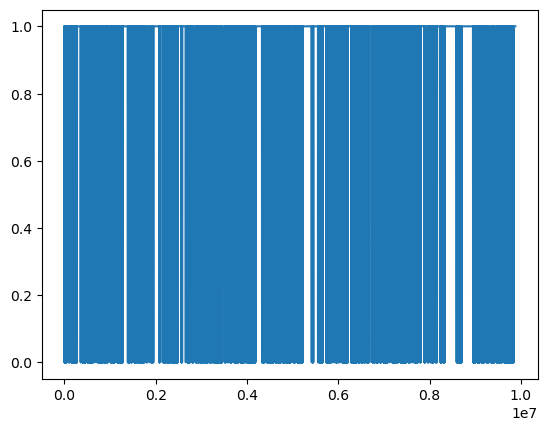

In [17]:
plt.plot(mask)

In [18]:
allDS_pdFrame = allDS.to_dataframe()

In [19]:
data = allDS_pdFrame.loc[~mask]
print(data.shape)

(1471618, 19)


In [20]:
# Assuming you have loaded your data into a DataFrame called 'data'

# Define your threshold for rain (8mm/hr)
rain_threshold = 5

# Label data based on precipitation rate
data['PREC'] =np.log(data['RAIN']) #+ 20 #np.min(data['RAIN'].to_numpy()) #5 #np.where(data['RAIN'] < 0, 0, data['RAIN'])
#data['PREC'] = np.where(data['RAIN'] > 100, 100, data['PREC'])

# Drop rows with missing values
#data.dropna(inplace=True)

# Define features and target variable
features = ['lat','lon','SST', 'U10N', #'U10_direction', 
            'twoHrStdWspd', 'twoHrStdWdir', 
            'AIRT', 'RH']

# features = ['SST',
#             'AIRT',
#             'RH']

target = 'PREC'

# Split data into features and target
X = data[features].to_numpy()
y = data[target].to_numpy()

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
y_scaled = (y - np.mean(y))/np.std(y)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

/tmp/ipykernel_2337618/532619497.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['PREC'] =np.log(data['RAIN']) #+ 20 #np.min(data['RAIN'].to_numpy()) #5 #np.where(data['RAIN'] < 0, 0, data['RAIN'])


In [21]:
print(np.min(X_scaled, axis=0))
print(np.max(X_scaled, axis=0))
print(np.min(y_train, axis=0))
print(np.max(y_train, axis=0))

print(np.min(y_test, axis=0))
print(np.max(y_test, axis=0))

[-1.83782735 -1.35154841 -4.22344888 -2.40294785 -1.40103197 -0.52493201
 -4.42876253 -5.24796299]
[ 1.6632431   1.3332703   2.5825604   8.50590463 15.38479943  4.65118838
  3.36752986  3.01331821]
-4.605170208339834
5.271716684750857
-4.605170208339834
4.895374062285059


In [1]:
def custom_activation(x):
    return (K.exp(x) - 5)

get_custom_objects().update({'custom_activation': custom_activation})

# Build the model
# model = Sequential([
#     Dense(8, activation='swish', input_shape=(X_train.shape[1],)),
#     Dropout(0.2),
#     Dense(8, activation='swish'),
#     Dropout(0.2),
#     Dense(8, activation='swish'),
#     Dropout(0.2),
#     Dense(8, activation='swish'),
#     Dropout(0.2),
#     Dense(8, activation='swish'),
#     Dropout(0.2),
#     Dense(8, activation='swish'),
#     Dropout(0.2),
#     # Dense(3, activation='exponential'), 
#     # Dropout(0.2),
#     #Dense(7, activation='relu'),
#     #Dense(1, activation='exponential'),
#     Dense(1, activation='relu')
# ])

model = Sequential([
    Dense(8, activation='tanh', input_shape=(X_train.shape[1],)),
    Dropout(0.2),
    # Dense(3, activation='exponential'), 
    # Dropout(0.2),
    #Dense(7, activation='relu'),
    #Dense(1, activation='exponential'),
    Dense(1, activation='linear')
])

# Compile the model
# model.compile(optimizer=Adam(learning_rate=0.001),
#               loss='binary_crossentropy',
#               metrics=['accuracy'])

model.compile(optimizer='nadam', loss='MeanSquaredLogarithmicError', metrics=['mape'])

# Train the model
history = model.fit(X_train, y_train, epochs=200, batch_size=100000, validation_split=0.2)

# Evaluate the model
#test_loss, test_mae = model.evaluate(X_test, y_test)

#print(f'Test Loss: {test_loss}')
#print(f'Test Mean Absolute Error: {test_mae}')

NameError: name 'get_custom_objects' is not defined

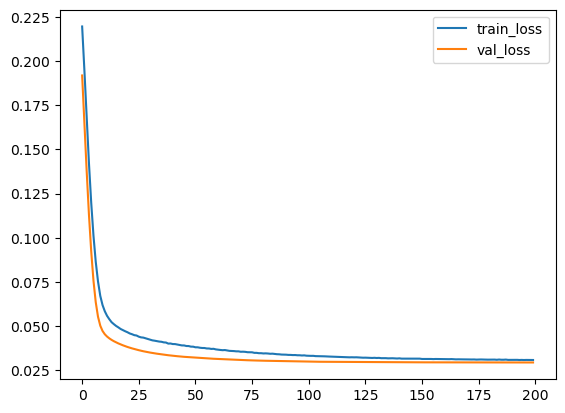

In [23]:
plt.plot(history.history['loss'], label='train_loss')
plt.plot(history.history['val_loss'], label='val_loss')
plt.legend()

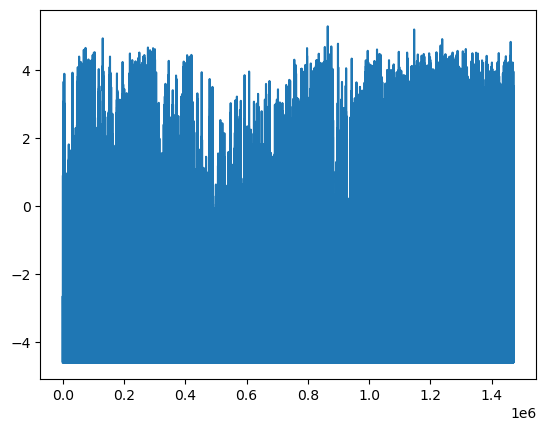

In [24]:
plt.plot(data['PREC'].to_numpy())

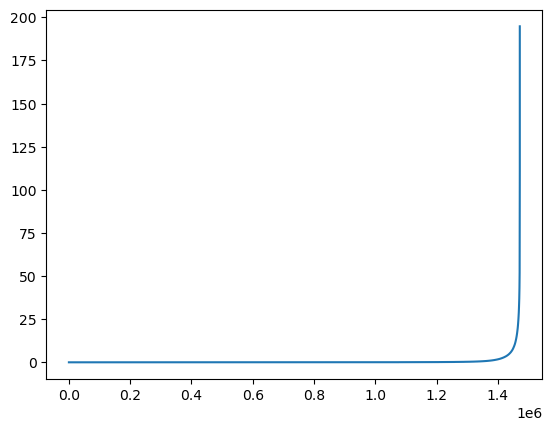

In [25]:
plt.plot(np.sort(data['RAIN'].to_numpy()))
#plt.plot(np.exp(np.arange(0,10,0.1)))

In [26]:
# Make predictions
predictions = model.predict(X_test)

# # Display predictions
# print(predictions)



9198/9198 [==============================] - 12s 1ms/step


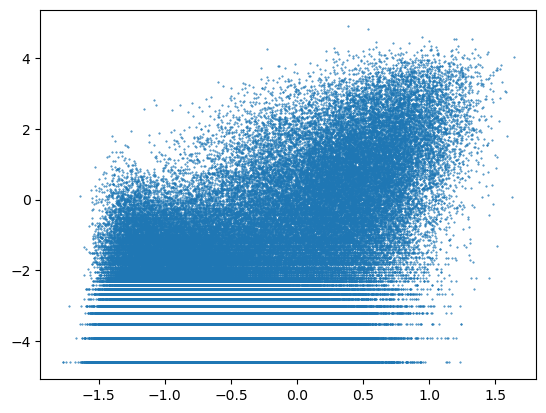

In [28]:
plt.scatter(predictions[:,0], y_test[:], s = 0.2)

In [ ]:
#y_train[0]

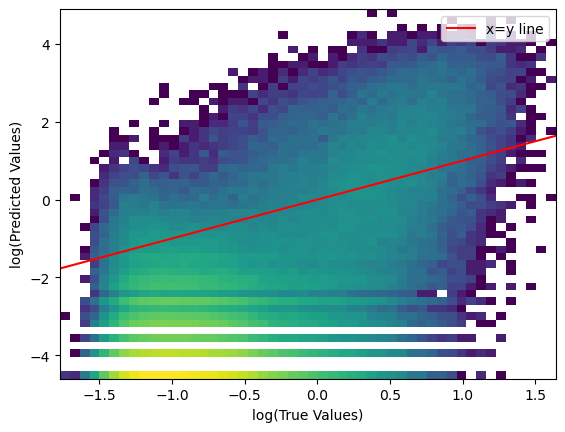

In [33]:
plt.hist2d(predictions[:,0], y_test, bins = (50,50), norm=colors.LogNorm()) 
plt.xlabel('log(True Values)')
plt.ylabel('log(Predicted Values)')#(np.linspace(-2,2,50),np.linspace(-2,2,50))
plt.plot(np.arange(-4,4,0.5), np.arange(-4,4,0.5), c ='r', label='x=y line')
plt.legend()

In [ ]:
np.max(y_test), np.min(y_test)

In [ ]:
np.max(predictions), np.min(predictions)

In [ ]:
#predictions = predictions[:,0]
predictions.shape, y_test.shape

In [ ]:
np.corrcoef(predictions[:,0], y_test)

In [ ]:
# Y_scaled = scaler.fit_transform(y)
# Y_scaled.shape
fig = plt.figure(figsize=(20,3))
#mask = X_test['lat']>3 #np.logical_and(y_test < 20, y_test > 3 )
plt.plot(10**(y_test[0:1000]), alpha = 0.5)
plt.plot(10**(predictions[0:1000]), alpha = 0.5)
plt.ylim(-0.1,10)

In [316]:
y_test.shape

(418969,)

In [317]:
train_predictions = model.predict(X_train)

52372/52372 [==============================] - 75s 1ms/step


In [ ]:
train_predictions = train_predictions[:,0]
train_predictions.shape, y_train.shape

In [ ]:
np.corrcoef(train_predictions, y_train)

In [ ]:
plt.scatter(train_predictions, y_train, s = 0.1)

In [29]:
model.save("Rain.h5")

In [30]:
latList = [-9, -8, -5, -2, 0, 2, 5, 8, 9]
lonList = [-95, -110, -125, -140, -155, -170, -180, 165]

ylen = len(latList)
xlen = len(lonList)

taskList = []

for latId  in range(ylen):
    for lonId in range(xlen):
        taskList.append([latList[latId], lonList[lonId]])

ntasks = len(taskList)

i = 0
tlen = 0

metaData = np.empty((0,23), dtype=float)
metaDataIndex = ['time',
                 'lat', 
                 'lon',
                 'U10N_QS',
                 'U10N_dir_QS',
                 'satTimeDiff',
                 'dist',
                 'satLon',
                 'satLat',
                 'U10N_TAO',
                 'U10N_dir_TAO',
                 'U10N_TAO2',
                 'U10N_dir_TAO2',
                 'U10N_x_TAO2',
                 'U10N_y_TAO2',
                 'SST_TAO',
                 'RH_TAO',
                 'AIRT_TAO',
                 'wspdStd2hr_TAO',
                 'wdirStd2hr_TAO',
                 'wspdMean30min_TAO',
                 'wdirMean30min_TAO',
                 'Deployment Classifier']

for task in taskList:
    lat = task[0]
    lon = task[1]

    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):

        ds = Dataset(matchFname)
        arr = np.empty((0,1), dtype=float)
        for i in range(3,22):
            if i <= 8:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][0,:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                if len(arr) == 0:
                    arr = np.concatenate((arr, readArr), axis = 0)
                else:
                    arr = np.concatenate((arr, readArr), axis = 1)
            else:
                #print(i, metaDataIndex[i])
                readArr = np.array([ds.variables[metaDataIndex[i]][:]]).T
                #print(readArr.shape)
                #print(arr.shape)
                arr = np.concatenate((arr, readArr), axis = 1)

        latArr = np.array([len(arr)*[LAT]]).T
        lonArr = np.array([len(arr)*[LON]]).T
        timeArr = np.array(ds.variables['time'])

        # latArr = latArr[:,np.newaxis]
        # lonArr = lonArr[:,np.newaxis]
        timeArr = timeArr[:,np.newaxis]
        
        #print('lonArr', lonArr.shape)
        arr = np.concatenate((lonArr, arr), axis=1)

        #print('latArr', latArr.shape)
        arr = np.concatenate((latArr, arr), axis=1)

        #print('timeArr', timeArr.shape)
        arr = np.concatenate((timeArr, arr), axis=1)

        ds2 = Dataset(deployFileName)
        startDates = np.array(ds2.variables['startDate'])
        endDates = np.array(ds2.variables['endDate'])

        depNum = np.zeros((len(arr),1), dtype=int)
        c = 1
        for i in range(1,len(startDates)):
            mask = timeArr >= startDates[i]
            mask *= timeArr <= endDates[i]
            depNum[mask] = c
            c = c+1

        arr = np.concatenate((arr, depNum), axis=1)


        metaData = np.concatenate((metaData, arr), axis=0)
        #ds = ds.expand_dims('lat', axis= 0)

In [31]:
nanVals = np.sum(metaData[:,:-2], axis=1)
mask = np.isnan(nanVals)
print(np.sum(mask), metaData.shape)
metaData = metaData[~mask, :]
print(metaData.shape)

7925 (199611, 23)
(191686, 23)


In [32]:
df = pd.DataFrame(metaData, columns = metaDataIndex )
df['speedDiff'] = df['U10N_QS'] - df['U10N_TAO']
df['absSpeedDiff'] = abs(df['U10N_QS'] - df['U10N_TAO'])

dDiff = (df['U10N_dir_QS'] - df['U10N_dir_TAO'])%360
dDiff[dDiff > 180] -= 360 #- dDiff[dDiff > 180] 
dDiff[dDiff < -180] += 360
df['directionDiff'] = dDiff
df['absDirectionDiff'] = abs(dDiff)

In [33]:
df.keys()

Index(['time', 'lat', 'lon', 'U10N_QS', 'U10N_dir_QS', 'satTimeDiff', 'dist',
       'satLon', 'satLat', 'U10N_TAO', 'U10N_dir_TAO', 'U10N_TAO2',
       'U10N_dir_TAO2', 'U10N_x_TAO2', 'U10N_y_TAO2', 'SST_TAO', 'RH_TAO',
       'AIRT_TAO', 'wspdStd2hr_TAO', 'wdirStd2hr_TAO', 'wspdMean30min_TAO',
       'wdirMean30min_TAO', 'Deployment Classifier', 'speedDiff',
       'absSpeedDiff', 'directionDiff', 'absDirectionDiff'],
      dtype='object')

In [34]:
# 'SST', 'U10N', 'U10_direction', 
#             'twoHrStdWspd', 'twoHrStdWdir', 
#             'AIRT', 'RH'

subDF = df[['SST_TAO', 'U10N_TAO', 'U10N_dir_TAO', 'wspdStd2hr_TAO', 'wdirStd2hr_TAO', 'AIRT_TAO', 'RH_TAO']].copy()

In [35]:
subDF = subDF.rename(columns={'SST_TAO': 'SST',
                              'U10N_TAO': 'U10N',
                              'U10N_dir_TAO': 'U10_direction',
                              'wspdStd2hr_TAO': 'twoHrStdWspd',
                              'wdirStd2hr_TAO': 'twoHrStdWdir',
                              'AIRT_TAO': 'AIRT',
                              'RH_TAO': 'RH'})

In [36]:
X_new_scaled = scaler.transform(subDF)

/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


In [37]:
predictions = model.predict(X_new_scaled)
predicted_rain_labels = np.where(predictions >= 0.1, 1, 0)

5991/5991 [==============================] - 9s 1ms/step


In [38]:
np.sum(predicted_rain_labels ==1)

0

In [39]:
df['predicted_rain_labels'] = predicted_rain_labels

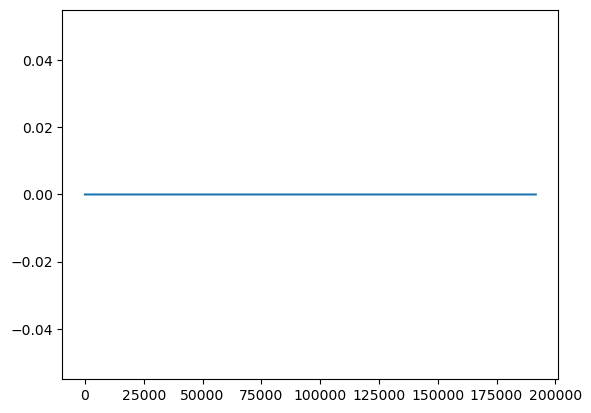

In [40]:
plt.plot(predicted_rain_labels)

In [41]:
def getGoodBad(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        

        return f' {goodCount:3.0f},{badCount:3.0f}'
    else:
        return ''

def getBadPercent(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        goodCount = len(subDF.loc[subDF['GoodBad'] == 'good'])/len(subDF)*100
        badCount = len(subDF.loc[subDF['GoodBad'] == 'bad'])/len(subDF)*100
        
        return badCount
    else:
        return -999


def getSpeedCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        QSspeed = subDF['U10N_QS'].to_numpy()
        TAOspeed = subDF['U10N_TAO'].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999


def getDirCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        QSdir = subDF['U10N_dir_QS'].to_numpy()
        TAOdir = subDF['U10N_dir_TAO'].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999
    

In [42]:
df.head()

,time,lat,lon,U10N_QS,U10N_dir_QS,satTimeDiff,dist,satLon,satLat,U10N_TAO,...,wspdStd2hr_TAO,wdirStd2hr_TAO,wspdMean30min_TAO,wdirMean30min_TAO,Deployment Classifier,speedDiff,absSpeedDiff,directionDiff,absDirectionDiff,predicted_rain_labels
0,315534600.0,-8.0,265.0,5.747140,325.648834,276.0,6.455491,265.053436,-7.976122,5.926161,...,0.175726,4.020722,5.905791,323.899994,0.0,-0.179021,0.179021,-0.751160,0.751160,0
1,315535200.0,-8.0,265.0,5.747140,325.648834,-324.0,6.455491,265.053436,-7.976122,5.836925,...,0.224447,4.074805,5.952141,324.433329,0.0,-0.089785,0.089785,3.848846,3.848846,0
2,315704400.0,-8.0,265.0,6.211579,323.708984,271.0,6.615148,264.974976,-7.945916,5.541527,...,0.492311,3.546156,5.676348,322.133331,0.0,0.670052,0.670052,2.408997,2.408997,0
3,315705000.0,-8.0,265.0,6.211579,323.708984,-329.0,6.615148,264.974976,-7.945916,5.992860,...,0.507882,3.787412,6.054171,320.299998,0.0,0.218719,0.218719,3.108978,3.108978,0
4,315749400.0,-8.0,265.0,5.837174,318.623627,457.0,5.688329,265.045563,-7.975894,6.055364,...,0.392188,5.910673,5.905311,320.266663,0.0,-0.218190,0.218190,0.823639,0.823639,0


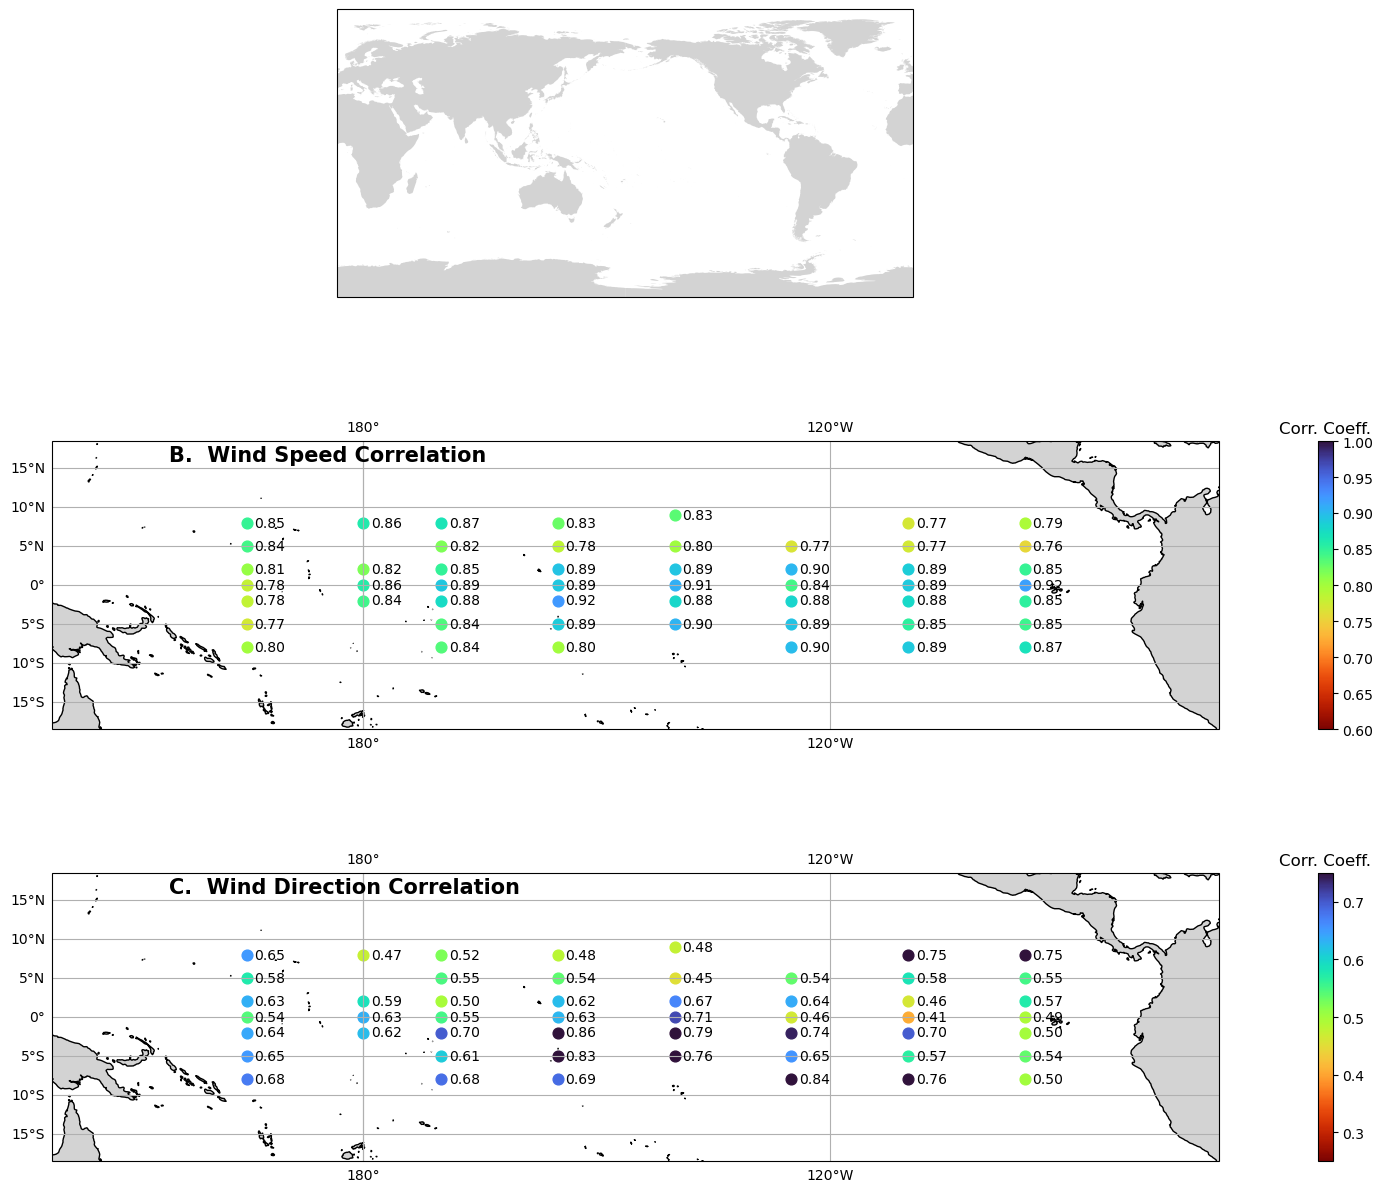

In [43]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


# ax.set_extent([140, -70, -5, 5]) 
# gridlines = ax.gridlines(draw_labels=True)
# ax.coastlines()
# for task in taskList:
#     lat = task[0]
#     lon = task[1]
#     txt = getGoodBad(lat, lon, df)
    

#     xpos = lon + 180
    
#     if xpos > 180:
#        xpos -= 360
#     if txt != '': 
#         badPercent = getBadPercent(lat, lon, df)
#         #print(badPercent)
#         ax.text(xpos, lat-0.5, txt)
#         x = ax.scatter(xpos, lat, c=badPercent, vmin=0, vmax=45, s=60, cmap='turbo')
    
# cb = plt.colorbar(x, ax = ax)
# cb.ax.set_title('% of Bad Matchups')
# #ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

# ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 15)


subDF = df.loc[df['predicted_rain_labels'] == 0]
ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.6, vmax=1, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.25, vmax=0.75, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/pypr

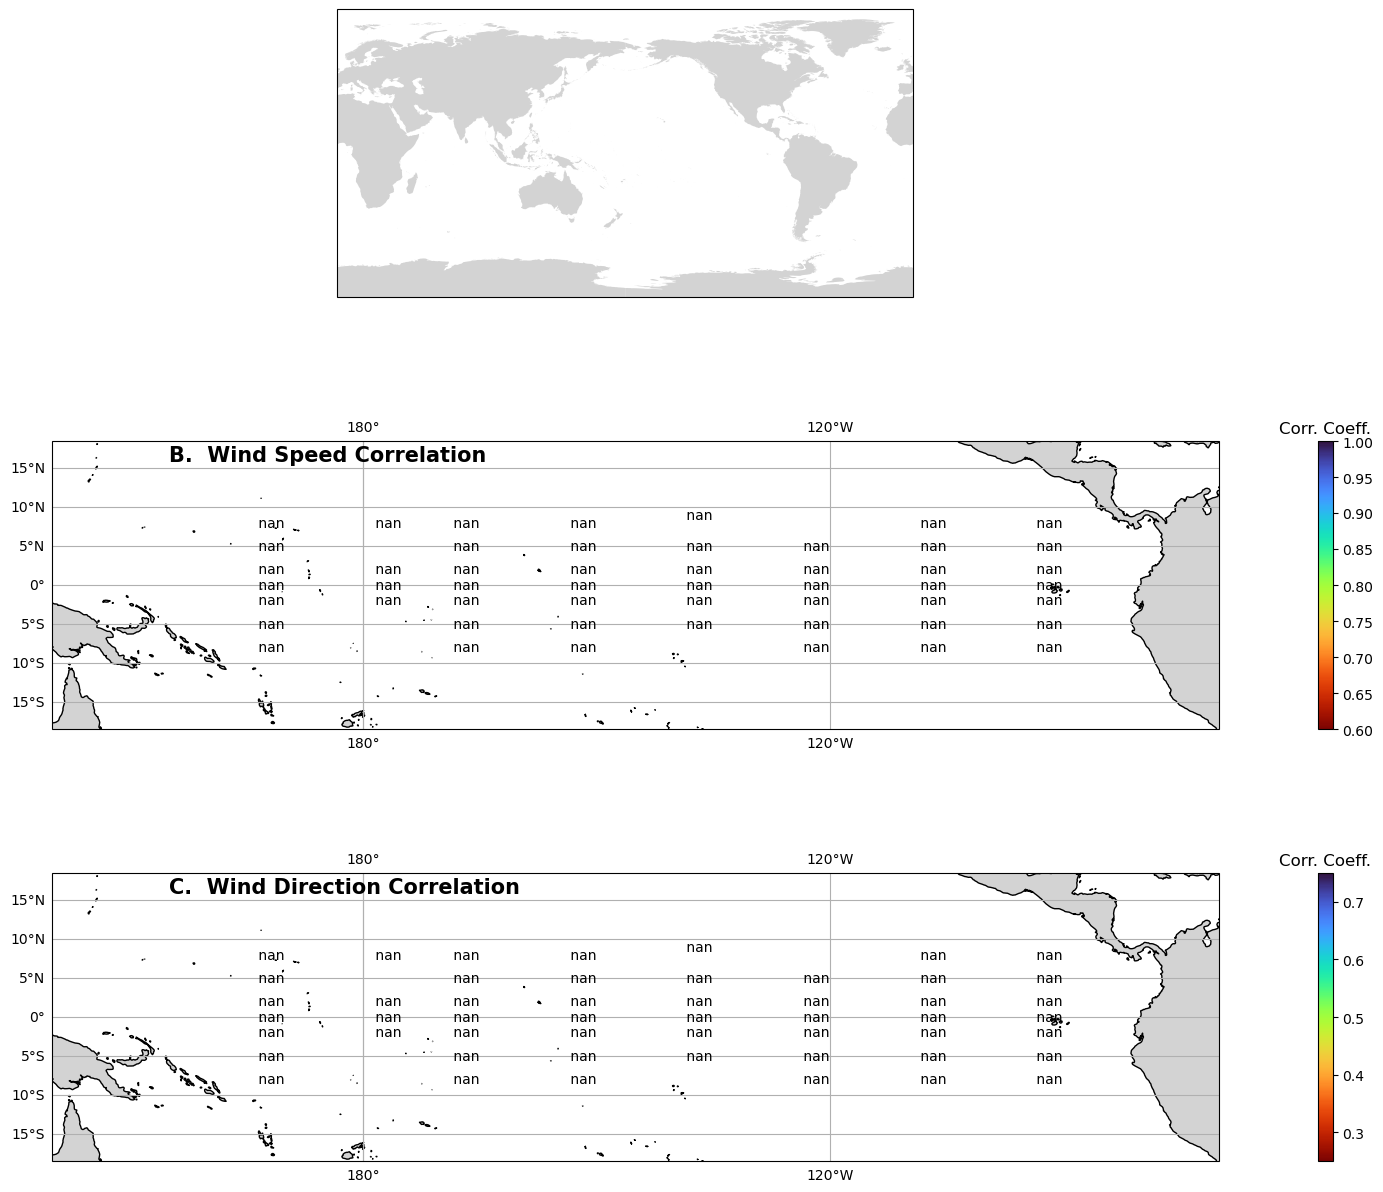

In [44]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


# ax.set_extent([140, -70, -5, 5]) 
# gridlines = ax.gridlines(draw_labels=True)
# ax.coastlines()
# for task in taskList:
#     lat = task[0]
#     lon = task[1]
#     txt = getGoodBad(lat, lon, df)
    

#     xpos = lon + 180
    
#     if xpos > 180:
#        xpos -= 360
#     if txt != '': 
#         badPercent = getBadPercent(lat, lon, df)
#         #print(badPercent)
#         ax.text(xpos, lat-0.5, txt)
#         x = ax.scatter(xpos, lat, c=badPercent, vmin=0, vmax=45, s=60, cmap='turbo')
    
# cb = plt.colorbar(x, ax = ax)
# cb.ax.set_title('% of Bad Matchups')
# #ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

# ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 15)


subDF = df.loc[df['predicted_rain_labels'] == 1]
ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.6, vmax=1, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.25, vmax=0.75, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)


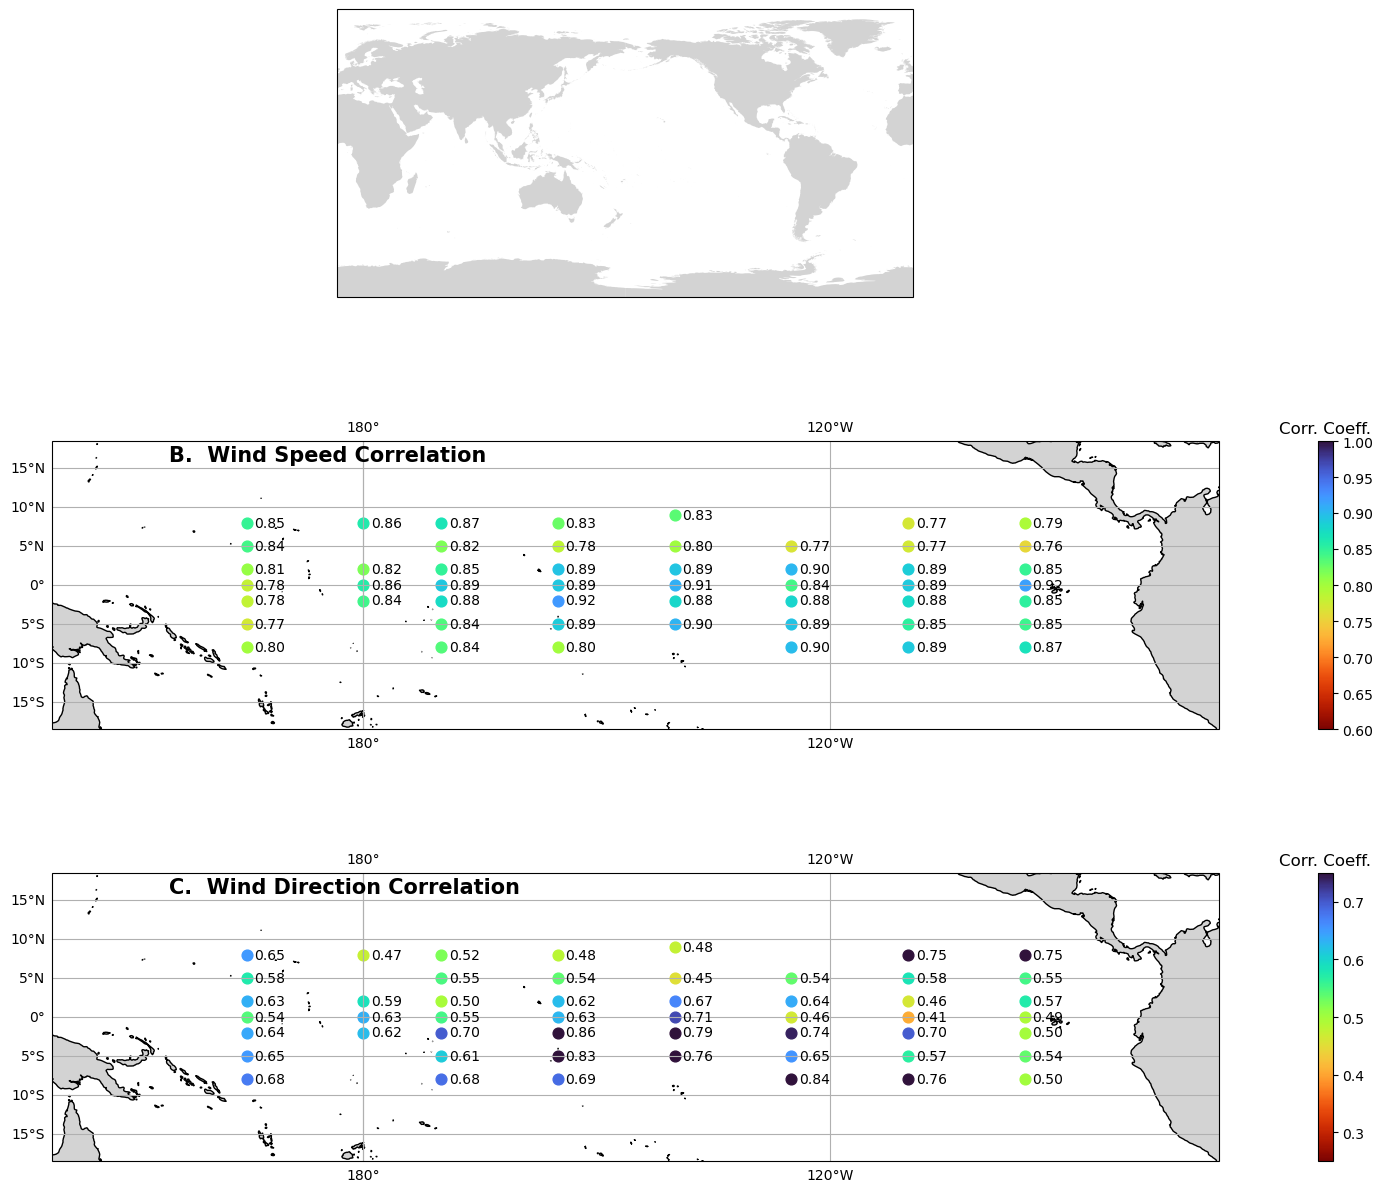

In [45]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


# ax.set_extent([140, -70, -5, 5]) 
# gridlines = ax.gridlines(draw_labels=True)
# ax.coastlines()
# for task in taskList:
#     lat = task[0]
#     lon = task[1]
#     txt = getGoodBad(lat, lon, df)
    

#     xpos = lon + 180
    
#     if xpos > 180:
#        xpos -= 360
#     if txt != '': 
#         badPercent = getBadPercent(lat, lon, df)
#         #print(badPercent)
#         ax.text(xpos, lat-0.5, txt)
#         x = ax.scatter(xpos, lat, c=badPercent, vmin=0, vmax=45, s=60, cmap='turbo')
    
# cb = plt.colorbar(x, ax = ax)
# cb.ax.set_title('% of Bad Matchups')
# #ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

# ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 15)


subDF = df #.loc[df['predicted_rain_labels'] == 1]
ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.6, vmax=1, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = getDirCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.25, vmax=0.75, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)


In [46]:
def get30minMeanSpeedCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        QSspeed = subDF['U10N_QS'].to_numpy()
        TAOspeed = subDF['wspdMean30min_TAO'].to_numpy()
        corr = np.corrcoef(QSspeed, TAOspeed)[0,1]
        return corr
    else:
        return -999


def get30minMeanDirCorrelation(lat, lon, df):
    LAT = lat
    LON = lon

    if lat < 0:
        latUnits = 'S'
    else:
        latUnits = 'N'

    if lon < 0:
        lonUnits = 'W'
        LON += 360
    else:
        lonUnits = 'E'
    
    lat=abs(lat)
    lon=abs(lon)

    matchFname = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_matchupNearestFour_2000.nc'
    deployFileName = f'../../downloads/Buoy/extractedGZ/WINDS/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}/T_{lat:02d}{latUnits}_{lon:03d}{lonUnits}_DeploymentDates.nc'
    
    if os.path.isfile(matchFname):
        subDF = df.loc[df['lat'] == LAT]
        subDF = subDF.loc[subDF['lon'] == LON]
        QSdir = subDF['U10N_dir_QS'].to_numpy()
        TAOdir = subDF['wdirMean30min_TAO'].to_numpy()
        corr = np.corrcoef(QSdir, TAOdir)[0,1]
        return corr
    else:
        return -999

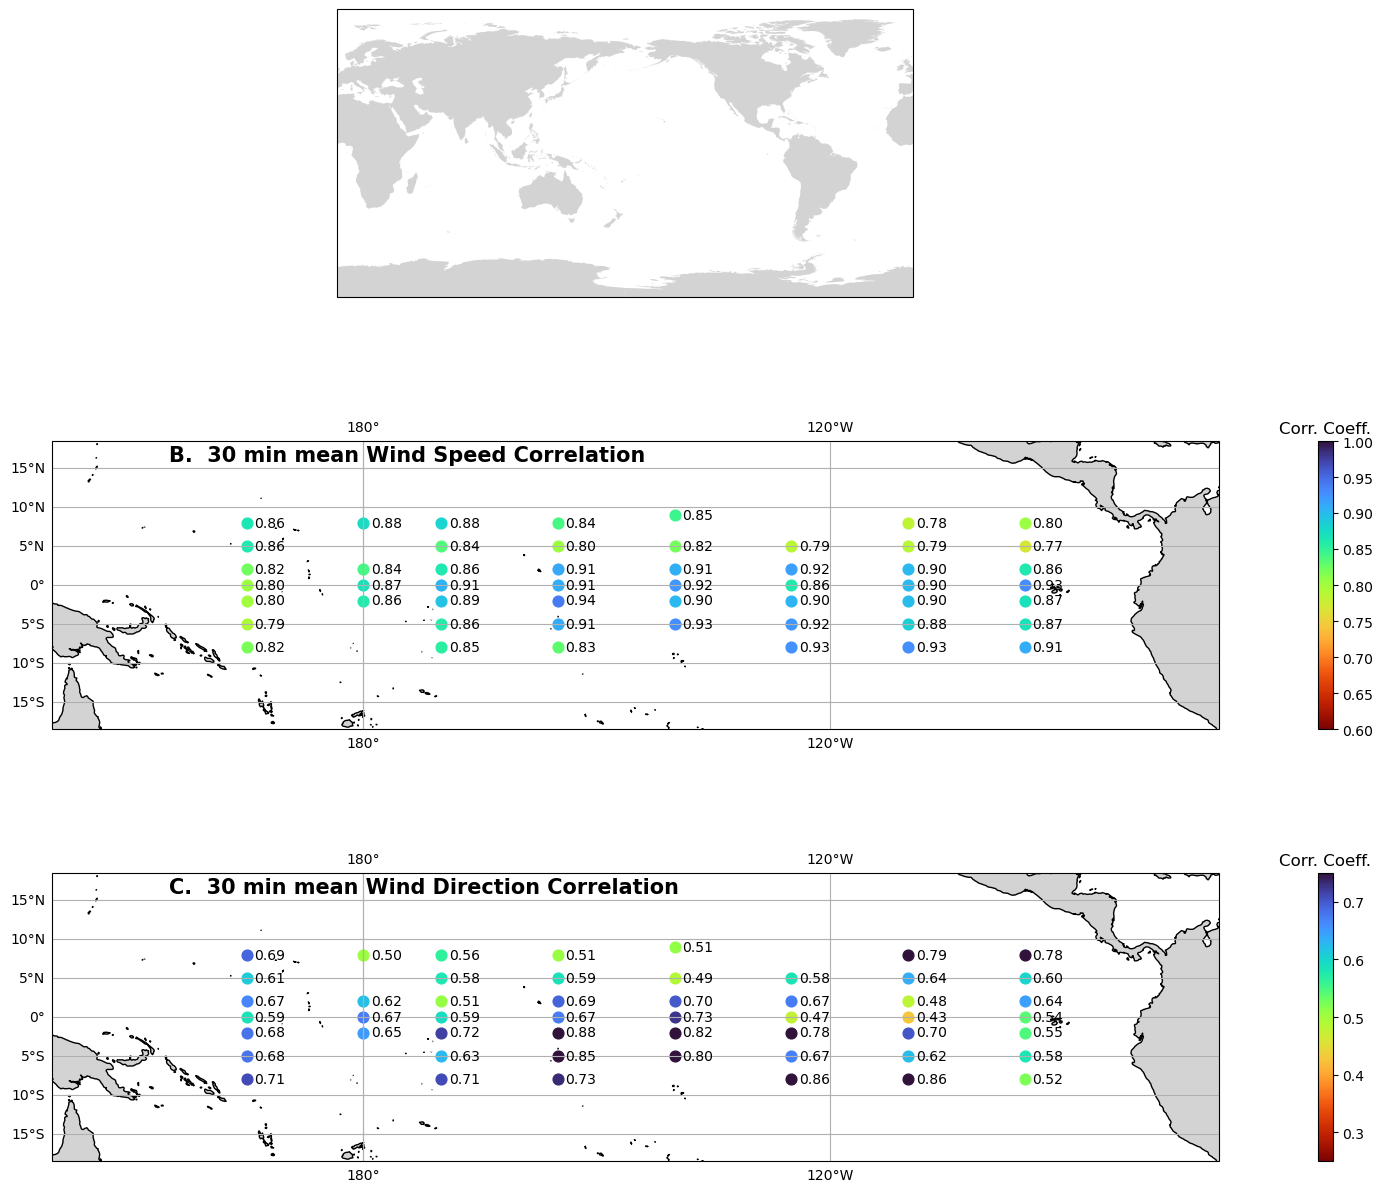

In [47]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


# ax.set_extent([140, -70, -5, 5]) 
# gridlines = ax.gridlines(draw_labels=True)
# ax.coastlines()
# for task in taskList:
#     lat = task[0]
#     lon = task[1]
#     txt = getGoodBad(lat, lon, df)
    

#     xpos = lon + 180
    
#     if xpos > 180:
#        xpos -= 360
#     if txt != '': 
#         badPercent = getBadPercent(lat, lon, df)
#         #print(badPercent)
#         ax.text(xpos, lat-0.5, txt)
#         x = ax.scatter(xpos, lat, c=badPercent, vmin=0, vmax=45, s=60, cmap='turbo')
    
# cb = plt.colorbar(x, ax = ax)
# cb.ax.set_title('% of Bad Matchups')
# #ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

# ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 15)


subDF = df.loc[df['predicted_rain_labels'] == 0]
ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = get30minMeanSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.6, vmax=1, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  30 min mean Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = get30minMeanDirCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.25, vmax=0.75, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  30 min mean Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)


/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/numpy/lib/function_base.py:518: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/numpy/lib/function_base.py:2845: RuntimeWarning: Degrees of freedom <= 0 for slice
  c = cov(x, y, rowvar, dtype=dtype)
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/numpy/lib/function_base.py:2704: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/shikhar.rai/anaconda3/envs/mpiNetCDF/lib/python3.11/site-packages/pypr

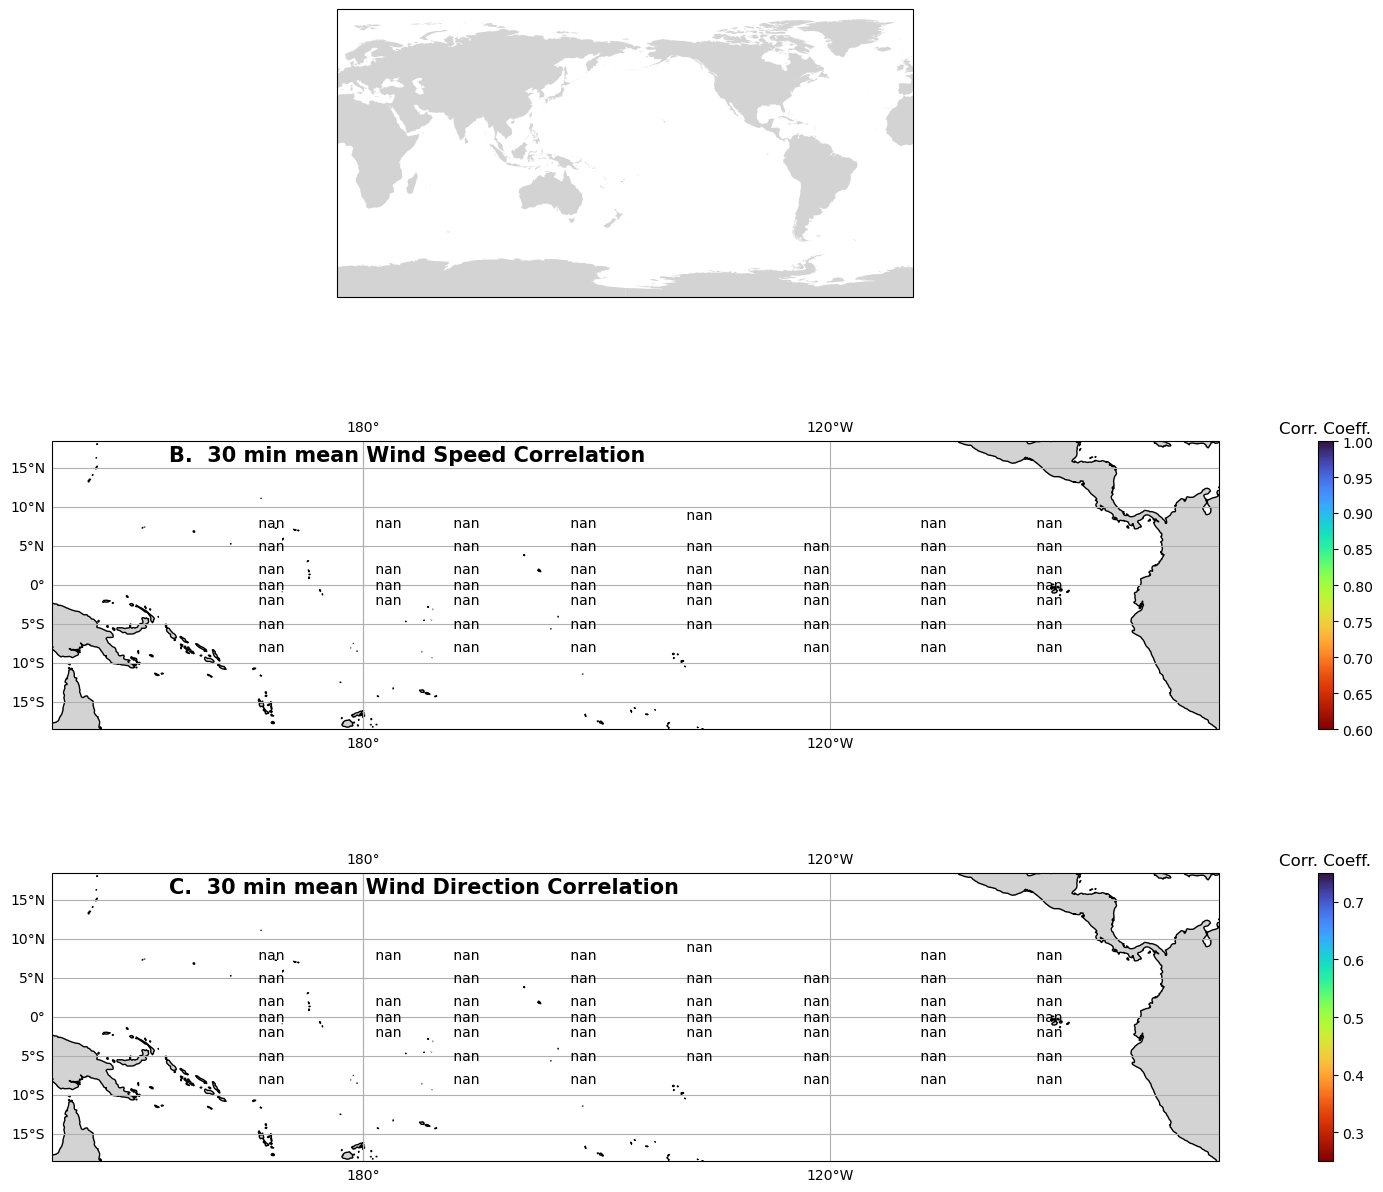

In [48]:
import cartopy.crs as ccrs
import cartopy.feature as cfeature 
fig, axes = plt.subplots(nrows = 3, 
                       ncols = 1, 
                        figsize = (20,12),
                       subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)}, # "aspect": 1.2}, #1.2},
                       gridspec_kw = {'wspace':0.2, 'hspace':0.5}) 

land = cfeature.NaturalEarthFeature(
    category='physical',
    name='land',
    scale='50m',
    facecolor='lightgrey'  # Set the color to grey
)

ax = axes[0] 

ax.add_feature(land)


# ax.set_extent([140, -70, -5, 5]) 
# gridlines = ax.gridlines(draw_labels=True)
# ax.coastlines()
# for task in taskList:
#     lat = task[0]
#     lon = task[1]
#     txt = getGoodBad(lat, lon, df)
    

#     xpos = lon + 180
    
#     if xpos > 180:
#        xpos -= 360
#     if txt != '': 
#         badPercent = getBadPercent(lat, lon, df)
#         #print(badPercent)
#         ax.text(xpos, lat-0.5, txt)
#         x = ax.scatter(xpos, lat, c=badPercent, vmin=0, vmax=45, s=60, cmap='turbo')
    
# cb = plt.colorbar(x, ax = ax)
# cb.ax.set_title('% of Bad Matchups')
# #ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

# ax.text(0.1, 0.95, 'A.  Percentage of Bad Matchups', horizontalalignment='left',
#         verticalalignment='center', transform=ax.transAxes,
#         weight = 'heavy', fontsize = 15)


subDF = df.loc[df['predicted_rain_labels'] == 1]
ax = axes[1]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = get30minMeanSpeedCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.6, vmax=1, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')

ax.text(0.1, 0.95, 'B.  30 min mean Wind Speed Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)


ax = axes[2]

ax.add_feature(land)

ax.set_extent([140, -70, -5, 5]) 
gridlines = ax.gridlines(draw_labels=True)
ax.coastlines()
for task in taskList:
    lat = task[0]
    lon = task[1]
    #txt = getGoodBad(lat, lon, df)
    

    xpos = lon + 180
    
    if xpos > 180:
       xpos -= 360
    corr = get30minMeanDirCorrelation(lat, lon, subDF)
    if corr != -999: 
        ax.text(xpos+1, lat-0.5, f'{corr:4.2f}')
        x = ax.scatter(xpos, lat, c=corr, vmin=0.25, vmax=0.75, s=60, cmap='turbo_r')
    
cb = plt.colorbar(x, ax = ax)
cb.ax.set_title('Corr. Coeff.')
#ax.scatter(df['lon'], df['lat'], transform=ccrs.PlateCarree())

ax.text(0.1, 0.95, 'C.  30 min mean Wind Direction Correlation', horizontalalignment='left',
        verticalalignment='center', transform=ax.transAxes,
        weight = 'heavy', fontsize = 15)

plt.subplots_adjust(left = 0.01, right = 1, top =0.98 , bottom = 0.02, wspace=0 , hspace=0)
#plt.tight_layout()

#plt.savefig('goodVsBad.png', dpi=100)
